In [ ]:
#   █████╗ ███████╗███████╗██████╗  ██████╗ ██████╗ ██╗  ██╗
#  ██╔══██╗██╔════╝██╔════╝╚════██╗██╔═████╗╚════██╗██║  ██║
#  ███████║█████╗  █████╗   █████╔╝██║██╔██║ █████╔╝███████║
#  ██╔══██║██╔══╝  ██╔══╝  ██╔═══╝ ████╔╝██║██╔═══╝ ╚════██║
#  ██║  ██║██║     ██║     ███████╗╚██████╔╝███████╗     ██║
#  ╚═╝  ╚═╝╚═╝     ╚═╝     ╚══════╝ ╚═════╝ ╚══════╝     ╚═╝
#
#  ┏┓┓  ┓   ┏┓  ┓ ┓┏┓  ╻  ┏┓           •
#  ┣┫┃┏┓┣┓┏┓┣ ┏┓┃┏┫┏┛ ━╋━ ┣ ┏┓┓┏┏╋┏┓┏┓╋┓┏┓┏┓
#  ┛┗┗┣┛┛┗┗┻┻ ┗┛┗┗┻┗━  ╹  ┻ ┛ ┗┛┛┗┛ ┗┻┗┗┗┛┛┗
#     ┛
#       Predicting protein conformational motions
#  using energetic frustration analysis and AlphaFold2
#
#
#  VERSION Aug-01-2024

In [1]:
# ACCESS
repo_url = 'https://github.com/Gxy-with-luv/AFF2024.git'

# Clone the repository
!git clone {repo_url}

Cloning into 'AFF2024'...
remote: Enumerating objects: 5044, done.
remote: Counting objects: 100% (1561/1561), done.
remote: Compressing objects: 100% (569/569), done.
remote: Total 5044 (delta 1360), reused 1161 (delta 992), pack-reused 3483
Receiving objects: 100% (5044/5044), 168.97 MiB | 10.10 MiB/s, done.
Resolving deltas: 100% (3528/3528), done.
Updating files: 100% (5061/5061), done.


# Greetings

This is our notebook for a quick walkthrough.

With this one can get a frustration-energy landscape mapped from the MSA space using physically-based frustration information for AdK (with closed conformation as the native state) and then generate the alternative open state using High $\Delta E_{HF}$ region, masking and mixing methods.

**This is the simplist walkthough. For all codes, please refer to our Github repository: AFF2024**

## The structure of this notebook is listed as following:
- Greetings
- Installing & loading the prerequesites
- Frustration and Energy: Calculation and loading
- Building **the frustration-energy landscape**
- Sampling from low-$\Delta E_{HF}$ region to high-$\Delta E_{HF}$ region (**Sliding methods**)
- Generating metastable state (AdK open state) and also conformational changing pathway using **mixing methods**
- Generating metastable state (AdK open state) and also conformational changing pathway using HF-site **masking methods**



## The structure of our github repository:
### Core prediction part:

Using Colab is a convenient way to install and load AF2-related modules without the burden of configurations for environment. We provide a notebook: `Main_Prediction.ipynb` to load and use AlphaFold2, to predict structures from the MSA hints given by ourselves.

### AdK Folder:

``` bash
AdK # Every sub-folder also contain scripts for analysis and output results
├── Frustration-Energy-space # Mapping the MSA space onto the Frustration-Energy surface
│  ├── circ50 # Sliding from low dE_{HF} region towards high dE_{HF} region
│  ├── circ50higher # Sliding upwards to explore the energy surface learnt by AF2
│  ├── sampling400 # Random sampling for structure predictions
│  └── ...
│
├── AdK-erasing # Erasing/Masking highly-frustrated sites pushes the structure towards the open state
│  ├── erase_highFrus # top 30 with ratio 0.5, masking the most highly-frustrated sites
│  ├── erase_highFrus_various_ratio # Masking the most highly-frustrated sites with various masking ratio
│  ├── erase_lowFrus # Minimally-frustrated sites, as a control for comparison.
│  ├── erase_lowFrus_various_ratio # Minimally-frustrated sites, as a control for comparison.
│  ├── erase_nobreakage # Sites with no breakage during conformational change, as a control for comparison.
│  ├── erase_breakage # Sites with breakage during conformational change, as a control for comparison.
│  └── ...
│
├── AdK-mixing # Mixing for generating the conformational-changing pathway
│  ├── Mixing100 # Mixing with size of 100 sequences for the Open-state-set
│  ├── Mixing50 # Mixing with size of 50 sequences for the Open-state-set
│  └── ...
│
├── AdK-PCA_analysis # Containing PCA analysis for coordinates, distances(strain) and contacts(cracking) respectively
│
└── SI-AA_simulation # Gromacs setup files and also two output trajectories

```




# Installing & loading the prerequesites
might take 2 minutes using T4.

In [ ]:
!mkdir params
!curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar | tar x -C params
!git clone https://github.com/deepmind/alphafold.git
!pip -q install ml-collections dm-haiku biopython==1.81
!pip -q install mdtraj

Cloning into 'alphafold'...
remote: Enumerating objects: 984, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 984 (delta 11), reused 13 (delta 4), pack-reused 950
Receiving objects: 100% (984/984), 16.28 MiB | 16.34 MiB/s, done.
Resolving deltas: 100% (592/592), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.4 MB/s eta 0:00:00


In [ ]:
# Loading Modules
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import argparse
import hashlib
import jax
import jax.numpy as jnp
import re
import subprocess
from glob import glob
sys.path.append('alphafold')
from alphafold.model import model, config, data
from alphafold.data import parsers, pipeline
from alphafold.common import protein

# AlphaFold2 Functions
def make_model_runner(model_num=3, recycles=1, deterministic=True):
  model_name = 'model_%d_ptm' % model_num
  cfg = config.model_config(model_name)

  cfg.data.common.num_recycle = recycles
  cfg.model.num_recycle = recycles
  cfg.data.eval.num_ensemble = 1
  if deterministic:
    cfg.data.eval.masked_msa_replace_fraction = 0.0
    cfg.model.global_config.deterministic = True
  params = data.get_model_haiku_params(model_name, '.')

  return model.RunModel(cfg, params)

def make_processed_feature_dict(runner, a3m_file, name="test", seed=0):
  feature_dict = {}

  # assumes sequence is first entry in msa
  with open(a3m_file,'r') as msa_fil:
    sequence = msa_fil.read().splitlines()[1].strip()

  feature_dict.update(pipeline.make_sequence_features(sequence, name, len(sequence)))

  with open(a3m_file,'r') as msa_fil:
    msa = pipeline.parsers.parse_a3m(msa_fil.read())

  feature_dict.update(pipeline.make_msa_features([msa]))
  processed_feature_dict = runner.process_features(feature_dict, random_seed=seed)

  return processed_feature_dict

def parse_results(prediction_result, processed_feature_dict):
  b_factors = prediction_result['plddt'][:,None] * prediction_result['structure_module']['final_atom_mask']
  dist_bins = jax.numpy.append(0,prediction_result["distogram"]["bin_edges"])
  dist_mtx = dist_bins[prediction_result["distogram"]["logits"].argmax(-1)]
  contact_mtx = jax.nn.softmax(prediction_result["distogram"]["logits"])[:,:,dist_bins < 8].sum(-1)

  out = {"unrelaxed_protein": protein.from_prediction(processed_feature_dict, prediction_result, b_factors=b_factors),
        "plddt": prediction_result['plddt'],
        "pLDDT": prediction_result['plddt'].mean(),
        "dists": dist_mtx,
        "adj": contact_mtx}

  out.update({"pae": prediction_result['predicted_aligned_error'],
              "pTMscore": prediction_result['ptm']})
  return out

def write_results(result, pdb_out_path):
  plddt = float(result['pLDDT'])
  ptm = float(result["pTMscore"])
  print('plddt: %.3f' % plddt)
  print('ptm  : %.3f' % ptm)

  pdb_lines = protein.to_pdb(result["unrelaxed_protein"])
  with open(pdb_out_path, 'w') as f:
    f.write(pdb_lines)

/usr/local/lib/python3.10/dist-packages/Bio/Data/SCOPData.py:18: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  warnings.warn(


# Frustration and Energy: Calculation and loading

Frustration is calculated by Frustratometer web server (`RG Parra, et al., Protein frustratometer 2: a tool to localize energetic frustration in protein molecules, now with electrostatics.
Nucleic Acids Res 44, W356-W360 (2016).`) Please refer to our original paper for more details.

Energy is calculated by Rosetta (`CA Rohl, CE Strauss, KM Misura, D Baker, Protein structure prediction using rosetta in Methods Enzymol. (Elsevier) Vol. 383, pp.
66-93 (2004)`). The calculation scripts are provided in the folder: `Rosetta_scripts/`. And we would recommend running this on a cluster.

Now we load frustration informations and energy profiles:

In [ ]:
# MSA.a3m file --> Sequences
def a3m_seq_keep(msafile):
    seqs = []
    with open(msafile, 'r') as fi:
        for line in fi:
            if '>' not in line:
                seqs.append(line)
    alter = seqs[1:]
    alter_fin = []
    for alt in alter:
        seq = []
        for i in range(len(alt)):
            if alt[i] == '-':
                seq.append('-')
            else:
                seq.append(alt[i])
        seq = ''.join(seq)
        alter_fin.append(seq)
    return alter_fin

# Energy Loading
natseq = "MRIILLGAPGAGKGTQAQFIMEKYGIPQISTGDMLRAAVKSGSELGKQAKDIMDAGKLVTDELVIALVKERIAQEDCRNGFLLDGFPRTIPQADAMKEAGINVDYVLEFDVPDELIVDRIVGRRVHAPSGRVYHVKFNPPKVEGKDDVTGEELTTRKDDQEETVRKRLVEYHQMTAPLIGYYSKEAEAGNTKYAKVDGTKPVAEVRADLEKILG"
allseqs = a3m_seq_keep('AFF2024/AdK/Frustration-Energy-space/MSA.a3m')
scores = np.load('AFF2024/AdK/Frustration-Energy-space/ENE_sing.npy')
scores = scores.reshape([-1, 214])
natscore = np.load('AFF2024/AdK/Frustration-Energy-space/ENE_nat.npy')
natscore = natscore.reshape([-1, 214])
scores = scores - natscore

# Frustration Loading
filename = 'AFF2024/AdK/Frustration-Energy-space/frustration_configurational_5adens'
frustbox = []
with open(filename, 'r') as fi:
    for line in fi:
        if (len(line) > 5) and ('Residue' not in line):
            line = line.split()
            line = np.array(line[-3:]).astype(np.float32)
            frustbox.append(line)

frustbox = np.array(frustbox)
hif = frustbox[:, 0]
lof = frustbox[:, 2]


# Building the frustration-energy landscape

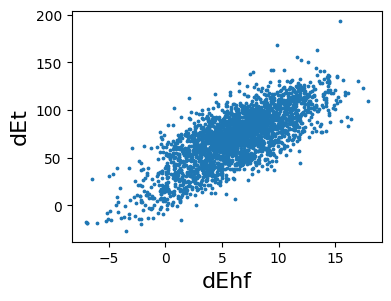

In [ ]:
# \delta E_{HF}
hifdot = np.dot(scores, hif)
# \delta E_{T}
alldot = np.sum(scores, axis=1)

# Visualization
plt.figure(dpi=100,figsize=(4,3))
plt.scatter(hifdot, alldot, s=3)
plt.xlabel('dEhf', fontsize=16)
plt.ylabel('dEt', fontsize=16)
plt.show()

# Sampling from low-$\Delta E_{HF}$ region to high-$\Delta E_{HF}$ region (Sliding methods)

In [ ]:
# If you would like to generate MSA-hints by yourself.
# You can also use the pre-geenrated MSA-hints.
!mkdir self_generate
!mkdir self_generate/circ50
!mkdir self_generate/circ50higher
!mkdir self_generate/sampling400

In [ ]:
# To select sequences around a dot (dE_HF, dE_T)
def a_given_point(x, y):
    dis = [np.sqrt(7.7**2*(hifdot[i]-x)**2 + (alldot[i]-y)**2)
           for i in range(len(alldot))]
    sorted_indices = np.argsort(dis)
    idx = sorted_indices[:50]
    return(idx)

# To get the minimal distance from the sequences to a chosen dot (dE_HF, dE_T)
def a_given_point_min(x, y):
    # To be used to see whether a sampling is successful in [Random sampling 400 times]
    dis = [np.sqrt(7.7**2*(hifdot[i]-x)**2 + (alldot[i]-y)**2)
           for i in range(len(alldot))]
    sorted_indices = np.argsort(dis)
    return(min(dis))

# Sliding Results (dEhf_dEt)
# This is Fig3C
# #############################################
for i in range(40):
    num = i/2-5
    idx = a_given_point(num, 0)
    with open('self_generate/circ50/circ'+str(i)+'.a3m', 'w') as fo:
        fo.write('>101\n')
        fo.write("MRIILLGAPGAGKGTQAQFIMEKYGIPQISTGDMLRAAVKSGSELGKQAKDIMDAGKLVTDELVIALVKERIAQEDCRNGFLLDGFPRTIPQADAMKEAGINVDYVLEFDVPDELIVDRIVGRRVHAPSGRVYHVKFNPPKVEGKDDVTGEELTTRKDDQEETVRKRLVEYHQMTAPLIGYYSKEAEAGNTKYAKVDGTKPVAEVRADLEKILG\n")
        count = 0
        for j in idx:
            fo.write('>'+str(count)+'\n')
            fo.write(allseqs[j])
# #############################################

# Additional Examples!
# Random sampling Results upon Higher dEt
# This is Fig5A
# #############################################
for ene_all in [20, 30, 40, 50, 60, 70, 80, 90, 100, 110]:
    idxbox = [i for i in range(len(alldot)) if np.abs(
        alldot[i]-ene_all) < 10 and hifdot[i] > 0]
    for i in range(30):
        idx = np.random.choice(idxbox, size=50, replace=False)
        with open('self_generate/circ50higher/circ'+str(ene_all)+'_'+str(i)+'.a3m', 'w') as fo:
            fo.write('>101\n')
            fo.write("MRIILLGAPGAGKGTQAQFIMEKYGIPQISTGDMLRAAVKSGSELGKQAKDIMDAGKLVTDELVIALVKERIAQEDCRNGFLLDGFPRTIPQADAMKEAGINVDYVLEFDVPDELIVDRIVGRRVHAPSGRVYHVKFNPPKVEGKDDVTGEELTTRKDDQEETVRKRLVEYHQMTAPLIGYYSKEAEAGNTKYAKVDGTKPVAEVRADLEKILG\n")
            count = 0
            for j in idx:
                fo.write('>'+str(count)+'\n')
                fo.write(allseqs[j])
                count += 1
# #############################################

# Additional Examples!
# Random sampling 400 times
# This is Fig2E
# #############################################
boxxy = []
for i in range(400):
    ifsuccess = False
    while ifsuccess == False:
        x = np.random.random()*27-7
        y = np.random.random()*150-20
        if a_given_point_min(x, y) < 2:
            ifsuccess = True
            boxxy.append([x, y])
        idxs = a_given_point(x, y)
        with open('self_generate/sampling400/samp'+str(i)+'.a3m', 'w') as fo:
            fo.write('>101\n')
            fo.write("MRIILLGAPGAGKGTQAQFIMEKYGIPQISTGDMLRAAVKSGSELGKQAKDIMDAGKLVTDELVIALVKERIAQEDCRNGFLLDGFPRTIPQADAMKEAGINVDYVLEFDVPDELIVDRIVGRRVHAPSGRVYHVKFNPPKVEGKDDVTGEELTTRKDDQEETVRKRLVEYHQMTAPLIGYYSKEAEAGNTKYAKVDGTKPVAEVRADLEKILG\n")
            count = 0
            for j in idxs:
                fo.write('>'+str(count)+'\n')
                fo.write(allseqs[j])
                count += 1
# #############################################

### AF2 Predictions
Consuming about 1-2 minutes per prediction using the default T4.

In [ ]:
# Running Predictions
# Time consuming. You can continue with our pre-generated data.
!mkdir predicted
n_recycles = 3
model_number = 3
seed=0
runner = make_model_runner(model_num=model_number, recycles=n_recycles)
# Please change to the dir you would like to run
MSA_hints = glob('AFF2024/AdK/Frustration-Energy-space/circ50/*.a3m')
count=0

for fil in MSA_hints:
  if os.path.exists('./predicted/'+ os.path.basename(fil).replace('.a3m','.pdb'))== False:
    features = make_processed_feature_dict(runner, fil, seed=seed)
    result = parse_results(runner.predict(features, random_seed=seed), features)
    pae = np.array(result['pae'])
    np.save('predicted/pae_' + os.path.basename(fil).replace('.a3m','_0.npy'), pae)
    write_results(result, 'predicted/' + os.path.basename(fil).replace('.a3m','.pdb'))
    count += 1

print('finished count:'+str(count))

### Results Analysis

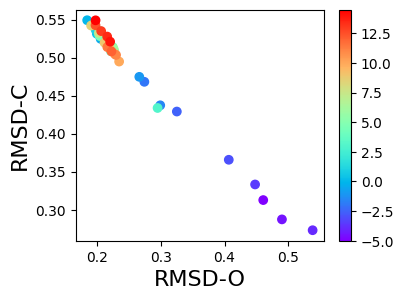

In [ ]:
# Example: Sliding Results (dEhf_dEt) Fig3C
import mdtraj as md

allbox1 = []
allbox2 = []
allpdb = []
hist = []

# Please replace the pdbdir and numbers with corresponding name and value.
pdbdir = 'AFF2024/AdK/Frustration-Energy-space/Predicted_results/circ50_results/'
bigbox = []
openpdb = md.load_pdb('AFF2024/AdK/Frustration-Energy-space/openCA.pdb')
closedpdb = md.load_pdb('AFF2024/AdK/Frustration-Energy-space/closedCA.pdb')
for roll in [0]:
    box1 = []
    box2 = []
    for num in np.arange(40):
        num = str(num)
        pdbfile = pdbdir + 'circ'+str(num)+ '.pdb'
        pdb = md.load_pdb(pdbfile)
        allpdb.append(pdb)
        atoms = pdb.top.select('name CA')
        pdb = pdb.atom_slice(atoms)
        pdb.superpose(openpdb, 0)
        d1 = md.rmsd(pdb, openpdb)
        pdb.superpose(closedpdb, 0)
        d2 = md.rmsd(pdb, closedpdb)
        box1.append(d1[0])
        box2.append(d2[0])
    allbox1.extend(box1)
    allbox2.extend(box2)

# Visualization, with colorbar showing the values of dE_HF
plt.figure(dpi=100,figsize=(4,3))
plt.scatter(allbox1, allbox2, c=np.arange(len(allbox1))/2-5, cmap='rainbow')
plt.xlabel('RMSD-O', fontsize=16)
plt.ylabel('RMSD-C', fontsize=16)
plt.colorbar()
plt.show()

Text(0, 0.5, 'Total_Energy')

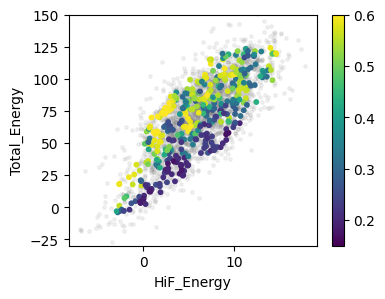

In [ ]:
# Additional Examples!
# Examples: 400 samplings
boxxy = []
rmsd = []
closedpdb = md.load_pdb('AFF2024/AdK/Frustration-Energy-space/closedCA.pdb')
openpdb = md.load_pdb('AFF2024/AdK/Frustration-Energy-space/openCA.pdb')

for roll in range(0,400):
    a3m = 'AFF2024/AdK/Frustration-Energy-space/sampling400/samp'+str(roll)+'.a3m'
    seqs = a3m_seq_keep(a3m)
    idxs = [allseqs.index(i) for i in seqs]
    x = np.mean(hifdot[idxs])
    y = np.mean(alldot[idxs])
    boxxy.append([x,y])
    pdb = 'AFF2024/AdK/Frustration-Energy-space/Predicted_results/sampling400_results/samp'+str(roll)+'.pdb'
    pdb = md.load_pdb(pdb)
    pdb = pdb.atom_slice(pdb.top.select('name CA'))
    rmsdc = md.rmsd(pdb, closedpdb)[0]
    rmsdo = md.rmsd(pdb, openpdb)[0]
    rmsd.append([rmsdc, rmsdo])

boxxy = np.array(boxxy)
rmsd = np.array(rmsd)

# Visualization with the color refering to RMSD-O
plt.figure(dpi=100, figsize=(4,3))
plt.scatter(hifdot, alldot, s=6, c='gray', alpha=0.1, marker='o')
plt.scatter(boxxy[:, 0], boxxy[:, 1], c=rmsd[:, 1], s=10, vmin=0.15, vmax=0.6)
plt.colorbar()
plt.ylim(-30,150)
plt.xlabel('HiF_Energy')
plt.ylabel('Total_Energy')

# Generating metastable state (AdK open state) and also conformational changing pathway using mixing methods

1. Closed MSA Hints with low d_E_{HF} values (size 500) vs. Open MSA Hints with high d_E_{HF} values (size 50) --> Mixing50, w: 0.01~0.4; (since size 500 is a large values, w=0.4 is already big enough to see fully closed structures.)

2. Closed MSA Hints with low d_E_{HF} values (size 500) vs. Open MSA Hints with high d_E_{HF} values (size 100) --> Mixing100, w: 0.01~0.09; (since size 500 is a large values, plus adding the MSA set size would bias the closed state, w=0.09 is already big enough to see fully closed structures.)

In [ ]:
# Mixing Function
def mix_msa(msafile1, msafile2, ratio):
    seq1 = a3m_seq_keep(msafile1)
    seq2 = a3m_seq_keep(msafile2)
    np.random.shuffle(seq1)
    np.random.shuffle(seq2)
    N1 = len(seq1)
    N2 = len(seq2)
    seq1 = seq1[:int(N1*ratio)]
    seq2 = seq2[:N2 - int(N2*ratio)]
    seq1.extend(seq2)
    np.random.shuffle(seq1)
    return(seq1)

# Chosen Sequences to Output MSA Hints
def seq_to_a3m(seq, outfile):
    with open(outfile, 'w') as fo:
        natseq = "MRIILLGAPGAGKGTQAQFIMEKYGIPQISTGDMLRAAVKSGSELGKQAKDIMDAGKLVTDELVIALVKERIAQEDCRNGFLLDGFPRTIPQADAMKEAGINVDYVLEFDVPDELIVDRIVGRRVHAPSGRVYHVKFNPPKVEGKDDVTGEELTTRKDDQEETVRKRLVEYHQMTAPLIGYYSKEAEAGNTKYAKVDGTKPVAEVRADLEKILG"  # Example sequence
        fo.write('>101\n')
        fo.write(natseq+'\n')
        for i in range(len(seq)):
            fo.write('>'+str(i)+'\n')
            fo.write(seq[i])



!mkdir self_generate/Mixing50
!mkdir self_generate/Mixing100

# 1. Mixing 50
msafile1 = 'AFF2024/AdK/AdK-mixing/Closed500.a3m'
msafile2 = 'AFF2024/AdK/AdK-mixing/Open50.a3m'
for ratio in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
    0.1, 0.2, 0.3, 0.4]:
    for roll in range(10):
        seq = mix_msa(msafile1, msafile2, ratio)
        outfile = 'self_generate/Mixing50/mix'+str(round(ratio, 3))+'_'+str(roll)+'.a3m'
        seq_to_a3m(seq, outfile)

# 2. Mixing 100
msafile1 = 'AFF2024/AdK/AdK-mixing/Closed500.a3m'
msafile2 = 'AFF2024/AdK/AdK-mixing/Open100.a3m'
for ratio in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]:
    for roll in range(10):
        seq = mix_msa(msafile1, msafile2, ratio)
        outfile = 'self_generate/Mixing100/mix'+str(round(ratio, 3))+'_'+str(roll)+'.a3m'
        seq_to_a3m(seq, outfile)

### AF2 Predictions

In [ ]:
# Running Predictions
# Time consuming. You can continue with our pre-generated data.
n_recycles = 3
model_number = 3
seed=0
runner = make_model_runner(model_num=model_number, recycles=n_recycles)
# Please change to the dir you would like to run
MSA_hints = glob('AFF2024/AdK/AdK-mixing/Mixing100/*.a3m')
count=0

for fil in MSA_hints:
  if os.path.exists('./predicted/'+ os.path.basename(fil).replace('.a3m','.pdb'))== False:
    features = make_processed_feature_dict(runner, fil, seed=seed)
    result = parse_results(runner.predict(features, random_seed=seed), features)
    pae = np.array(result['pae'])
    np.save('predicted/pae_' + os.path.basename(fil).replace('.a3m','_0.npy'), pae)
    write_results(result, 'predicted/' + os.path.basename(fil).replace('.a3m','.pdb'))
    count += 1

print('finished count:'+str(count))

### Results Analysis

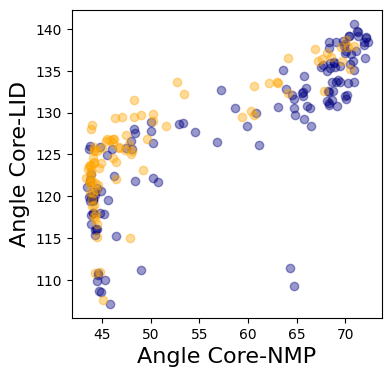

In [ ]:
# Now we use angles for visualizing the conformational changing pathway.
# If you would like to view the resulting RMSDs, please use the same way as
# "Sampling from low-dE_HF  region to high-dE_HF  region (Sliding methods" - "Results Analysis"

# First we merge the generated structrues (PDBs) into a single trajectory
def merge_pdb_files(directory):
    # List to store individual trajectories
    traj_list = []
    # Iterate over all files in the directory
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.pdb'):
            # Load each PDB file and append to the traj_list
            filepath = os.path.join(directory, filename)
            traj = md.load(filepath)
            traj_list.append(traj)
    # Concatenate all trajectories into a single trajectory
    if traj_list:
        combined_traj = md.join(traj_list)
        return combined_traj
    else:
        raise ValueError("No PDB files found in the directory")


def get_angle_lst(directory):
  traj = merge_pdb_files(directory)
  # Definition of Angles
  CAs = traj.top.select('name CA')
  corelid = [i for i in traj.top.select('resid >= 114') if i in traj.top.select('resid <= 124')]
  corelid = [i for i in corelid if i in CAs]
  core = [i for i in traj.top.select('resid >= 89') if i in traj.top.select('resid <= 99')]
  core = [i for i in core if i in CAs]
  nmp = [i for i in traj.top.select('resid >= 34') if i in traj.top.select('resid <= 54')]
  nmp = [i for i in nmp if i in CAs]
  core2 = [i for i in traj.top.select('resid >= 178') if i in traj.top.select('resid <= 184')]
  core2 = [i for i in core2 if i in CAs]
  lid = [i for i in traj.top.select('resid >= 124') if i in traj.top.select('resid <= 152')]
  lid = [i for i in lid if i in CAs]
  corelidxyz = np.mean(np.array([traj.xyz[:,i,:] for i in corelid]), axis=0)
  corexyz = np.mean(np.array([traj.xyz[:,i,:] for i in core]), axis=0)
  core2xyz = np.mean(np.array([traj.xyz[:,i,:] for i in core2]), axis=0)
  nmpxyz = np.mean(np.array([traj.xyz[:,i,:] for i in nmp]), axis=0)
  lidxyz = np.mean(np.array([traj.xyz[:,i,:] for i in lid]), axis=0)

  # Calculation of Angles
  ang1s = []
  ang2s = []
  for frame in range(len(traj)):
      corelid_core = np.linalg.norm(corelidxyz[frame] - corexyz[frame])
      core_nmp = np.linalg.norm(nmpxyz[frame] - corexyz[frame])
      corelid_nmp = np.linalg.norm(corelidxyz[frame] - nmpxyz[frame])

      core2_corelid = np.linalg.norm(core2xyz[frame] - corelidxyz[frame])
      corelid_lid = np.linalg.norm(corelidxyz[frame] - lidxyz[frame])
      core2_lid = np.linalg.norm(core2xyz[frame] - lidxyz[frame])

      ang1 = np.arccos((corelid_core**2 + core_nmp**2 - corelid_nmp**2)/2/corelid_core/core_nmp)/np.pi*180
      ang2 = np.arccos((core2_corelid**2 + corelid_lid **2 - core2_lid**2)/2/core2_corelid/corelid_lid)/np.pi*180

      ang1s.append(ang1)
      ang2s.append(ang2)
  return ang1s, ang2s

directory = 'AFF2024/AdK/AdK-mixing/Mixing50_results/'
ang1s_50, ang2s_50 = get_angle_lst(directory)
directory = 'AFF2024/AdK/AdK-mixing/Mixing100_results/'
ang1s_100, ang2s_100 = get_angle_lst(directory)

# Visualization

plt.figure(dpi=100, figsize=(4,4))
plt.scatter(ang1s_50, ang2s_50, c='navy', alpha=0.4, marker='o')
plt.scatter(ang1s_100, ang2s_100, c='orange', alpha=0.4, marker='o')
plt.xlabel('Angle Core-NMP', fontsize=16)
plt.ylabel('Angle Core-LID', fontsize=16)
plt.show()

# Generating metastable state (AdK open state) and also conformational changing pathway using HF-site masking methods
Here we show the results of masking the top 30 HF/MF sites with ratio=0.5.

In [ ]:
# Masking the top 30 HF sites with ratio=0.5
!mkdir self_generate/erase_highFrus
!mkdir self_generate/erase_lowFrus
sorted_indices = np.argsort(hif)[::-1]
msafile = 'AFF2024/AdK/AdK-erasing/original50.a3m'
for ratio in [0.5]: # Change this into 0.1~0.9 to reproduce erase_highFrus_various_ratio
    for roll in np.arange(80):
        lst = sorted_indices[:30]
        ratio = round(ratio,1)
        newseqs = []
        seqs = a3m_seq_keep(msafile)
        for seq in seqs:
            dice = np.random.random()
            if dice < ratio:
                seq = list(seq)
                for bar in lst:
                    seq[bar] = '-'
                seq = ''.join(seq)
            newseqs.append(seq)
        with open('self_generate/erase_highFrus/erase'+str(ratio)+'_'+str(roll)+'.a3m', 'w') as fo:
            fo.write('>101\n')
            fo.write('MRIILLGAPGAGKGTQAQFIMEKYGIPQISTGDMLRAAVKSGSELGKQAKDIMDAGKLVTDELVIALVKERIAQEDCRNGFLLDGFPRTIPQADAMKEAGINVDYVLEFDVPDELIVDRIVGRRVHAPSGRVYHVKFNPPKVEGKDDVTGEELTTRKDDQEETVRKRLVEYHQMTAPLIGYYSKEAEAGNTKYAKVDGTKPVAEVRADLEKILG\n')
            for seq in range(len(newseqs)):
                fo.write('>'+str(seq)+'\n')
                fo.write(newseqs[seq])

# Masking the top 30 MF sites with ratio=0.5
sorted_indices = np.argsort(lof)[::-1]
for ratio in [0.5]: # Change this into 0.1~0.9 to reproduce erase_lowFrus_various_ratio
    for roll in np.arange(80):
        lst = sorted_indices[:30]
        ratio = round(ratio,1)
        newseqs = []
        seqs = a3m_seq_keep(msafile)
        for seq in seqs:
            dice = np.random.random()
            if dice < ratio:
                seq = list(seq)
                for bar in lst:
                    seq[bar] = '-'
                seq = ''.join(seq)
            newseqs.append(seq)
        with open('self_generate/erase_lowFrus/erase'+str(ratio)+'_'+str(roll)+'.a3m', 'w') as fo:
            fo.write('>101\n')
            fo.write('MRIILLGAPGAGKGTQAQFIMEKYGIPQISTGDMLRAAVKSGSELGKQAKDIMDAGKLVTDELVIALVKERIAQEDCRNGFLLDGFPRTIPQADAMKEAGINVDYVLEFDVPDELIVDRIVGRRVHAPSGRVYHVKFNPPKVEGKDDVTGEELTTRKDDQEETVRKRLVEYHQMTAPLIGYYSKEAEAGNTKYAKVDGTKPVAEVRADLEKILG\n')
            for seq in range(len(newseqs)):
                fo.write('>'+str(seq)+'\n')
                fo.write(newseqs[seq])

### AF2 Prediction

In [ ]:
# Running Predictions
# Time consuming. You can continue with our pre-generated data.
n_recycles = 3
model_number = 3
seed=0
runner = make_model_runner(model_num=model_number, recycles=n_recycles)
# Please change to the dir you would like to run
MSA_hints = glob('AFF2024/AdK/AdK-erasing/erase_highFrus/*.a3m')
count=0

for fil in MSA_hints:
  if os.path.exists('./predicted/'+ os.path.basename(fil).replace('.a3m','.pdb'))== False:
    features = make_processed_feature_dict(runner, fil, seed=seed)
    result = parse_results(runner.predict(features, random_seed=seed), features)
    pae = np.array(result['pae'])
    np.save('predicted/pae_' + os.path.basename(fil).replace('.a3m','_0.npy'), pae)
    write_results(result, 'predicted/' + os.path.basename(fil).replace('.a3m','.pdb'))
    count += 1

print('finished count:'+str(count))

### Results Analysis
Here we use the distribution of RMSD to show that only the uncertainty upon HF-sites can effectively push the prediction out of the native state.

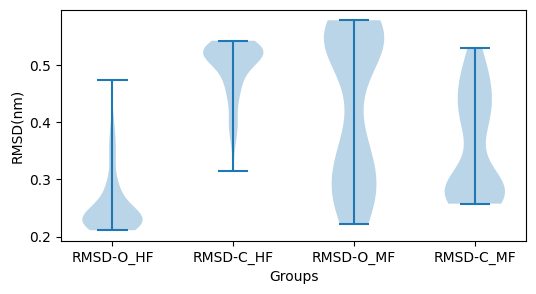

In [ ]:
# Collecting the results after masking HF/MF sites.
def get_rmsds(pdbdir):
  bigbox = []
  openpdb = md.load_pdb('AFF2024/AdK/Frustration-Energy-space/openCA.pdb')
  closedpdb = md.load_pdb('AFF2024/AdK/Frustration-Energy-space/closedCA.pdb')
  allbox1 = []
  allbox2 = []
  for roll in [0]:
      box1 = []
      box2 = []
      for num in np.arange(80):
          num = str(num)
          pdbfile = pdbdir + 'erase0.5_'+str(num)+ '.pdb'
          pdb = md.load_pdb(pdbfile)
          allpdb.append(pdb)
          atoms = pdb.top.select('name CA')
          pdb = pdb.atom_slice(atoms)
          pdb.superpose(openpdb, 0)
          d1 = md.rmsd(pdb, openpdb)
          pdb.superpose(closedpdb, 0)
          d2 = md.rmsd(pdb, closedpdb)
          box1.append(d1[0])
          box2.append(d2[0])
      allbox1.extend(box1)
      allbox2.extend(box2)
  return allbox1, allbox2

# Please replace the pdbdir and numbers with corresponding name and value.
pdbdir = 'AFF2024/AdK/AdK-erasing/erase_highFrus_results/'
allbox1_HF, allbox2_HF = get_rmsds(pdbdir)
pdbdir = 'AFF2024/AdK/AdK-erasing/erase_lowFrus_results/'
allbox1_MF, allbox2_MF = get_rmsds(pdbdir)

# Visualization
plt.figure(dpi=100,figsize=(6,3))
plt.violinplot([allbox1_HF, allbox2_HF, allbox1_MF, allbox2_MF])
labels = ['RMSD-O_HF', 'RMSD-C_HF', 'RMSD-O_MF', 'RMSD-C_MF']
plt.xticks([1, 2, 3, 4], labels)
plt.xlabel('Groups')
plt.ylabel('RMSD(nm)')
plt.show()

In [ ]:
#  Please refer to our Github for the complete codes.
#   _____ _                 _                        _
#  |_   _| |               | |                      | |
#    | | | |__   __ _ _ __ | | __  _   _  ___  _   _| |
#    | | | '_ \ / _` | '_ \| |/ / | | | |/ _ \| | | | |
#    | | | | | | (_| | | | |   <  | |_| | (_) | |_| |_|
#    \_/ |_| |_|\__,_|_| |_|_|\_\  \__, |\___/ \__,_(_)
#                                   __/ |
#                                  |___/